In [1]:
import ml_mr.simulation as mr_sim
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Serialization needs to use dill instead of pickle
# if custom functions are used.
import dill as pickle

In [2]:
sim = mr_sim.Simulation(100_000)

sim.parameters["h2"] = 0.2
sim.parameters["n_variants"] = 15

sim.parameters["ux_effect"] = 0.25
sim.parameters["uy_effect"] = -0.7
sim.parameters["xy_effect"] = 0.3  # Target parameter

# Noise
sim.parameters["x_e_std"] = np.sqrt(
    1 - sim.parameters["h2"] - sim.parameters["ux_effect"]  # FIXME
)
sim.parameters["y_e_std"] = 1

# Var(k * U), U ~ N(0,1)
# k^2 Var(U) = k^2

In [3]:
# Standard normal for the confounder
sim.add_variable(mr_sim.Normal("u", 0, 1))

# We generate the variant frequencies "outside" of
# the simulation model because it's not very important.
# This could also be done using real simulation variables
# to ensure resampling.
# We still record them as (fixed) simulation parameters.
@mr_sim.variable
def variant_frequencies(sim):
    return np.random.uniform(
        0.05,
        0.5 - 0.05,
        size=sim.get_sim_parameter("n_variants")
        # equivalently: sim.parameters["n_variants"]
    )
sim.add_sim_parameter(variant_frequencies)

freqs = sim.parameters["variant_frequencies"]
# We now simulate independant genetic variants.
for i in range(sim.parameters["n_variants"]):
    variant = mr_sim.Variant(f"v{i+1}", freqs[i])
    sim.add_variable(variant)

# We simulate variant effects.
# Note that these effects will yield the desired heritability
# only if var(g) = 1 (i.e. if the variants have been scaled).
sim.add_sim_parameter(
    mr_sim.Normal(
        "gx_effects",
        mu=0,
        sigma=np.sqrt(sim.parameters["h2"] / sim.parameters["n_variants"]),
        size=sim.parameters["n_variants"]
    )
)
    
# We now have everything to simulate the exposure.
@mr_sim.variable
def exposure(sim):
    variant_effects = sim.parameters["gx_effects"]
    
    x = 0
    for i in range(sim.parameters["n_variants"]):
        variant = sim.get_variable_data(f"v{i+1}")
        scaled_variant = (variant - np.mean(variant)) / np.std(variant)
        effect = variant_effects[i]
        
        x += effect * scaled_variant
    
    # Add effect of counfounder.
    x += sim.parameters["ux_effect"] * sim.get_variable_data("u")
    
    # Add residual noise.
    x += np.random.normal(0, scale=sim.parameters["x_e_std"], size=sim.n)
    
    return x
    

# And the outcome.
@mr_sim.variable
def outcome(sim):
    return (
        sim.parameters["xy_effect"] * sim.get_variable_data("exposure") +
        sim.parameters["uy_effect"] * sim.get_variable_data("u") +
        np.random.normal(0, scale=sim.parameters["y_e_std"], size=sim.n)
    )


sim.add_variable(exposure)
sim.add_variable(outcome)

In [4]:
# Simulations can be saved to disk as pairs of JSON + CSV files.
# The JSON contains simulation parameters and the CSV files contains
# simulated data.
sim.save(0)

# The resample method can be used to run the simulation again.
sim.resample()
sim.save(1)
!ls

basic_simulation_model.ipynb
bin_iv_varying_h2
mr_simulation_0_simulation_data.csv.gz
mr_simulation_0_simulation_parameters.json
mr_simulation_1_simulation_data.csv.gz
mr_simulation_1_simulation_parameters.json


In [5]:
# The individual level data is stored as a pandas dataframe.
sim._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,exposure,outcome
0,0.307013,0,1,1,1,0,0,1,0,1,0,0,1,1,2,1,0.768316,0.473755
1,-0.114443,1,0,1,0,0,1,0,0,0,1,0,2,1,1,1,1.459169,-0.363013
2,-0.032193,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0.821650,-0.044556
3,-0.626459,1,0,2,0,0,1,0,1,0,2,0,0,0,2,0,0.450312,-0.412453
4,0.755375,0,0,1,0,1,0,0,0,1,1,0,1,1,2,0,-0.619166,-1.128511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.437773,0,0,2,1,0,0,0,0,0,1,1,0,1,1,1,0.395290,0.230058
99996,0.923299,0,0,0,1,1,0,0,0,0,1,0,1,2,0,0,0.771113,0.216311
99997,-1.157023,0,0,1,0,0,1,0,1,0,0,1,2,0,1,0,-1.375335,0.548671
99998,2.296324,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,-0.861489,-2.769909


In [6]:
# Check how close we are to the desired heritability.
res = sm.OLS(
    sim.get_variable_data("exposure"),
    sm.add_constant(  # Adds intercept
        sim._data[[f"v{i+1}" for i in range(15)]]
    )
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               exposure   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     2057.
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:45:14   Log-Likelihood:            -1.1741e+05
No. Observations:              100000   AIC:                         2.349e+05
Df Residuals:                   99984   BIC:                         2.350e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2759      0.009     31.311      0.000       0.259       0.293
v1            -0.1430      0.007    -21.425      0.000      -0.156      -0.130
v2             0.2128      0.006     33.953      0.000       0.201       0.225
v3             0.0311      0.004      8.383      0.000       0.024       0.038
v4             0.0776      0.004     19.674      0.000       0.070       0.085
v5            -0.0822      0.004    -19.642      0.000      -0.090      -0.074
v6            -0.2577      0.004    -71.722      0.000      -0.265      -0.251
v7            -0.2736      0.006    -42.495      0.000      -0.286      -0.261
v8            -0.2093      0.004    -52.228      0.000      -0.217      -0.201
v9            -0.1038      0.004    -23.822      0.000      -0.112      -0.095
v10           -0.0864      0.004    -24.096      0.000      -0.093      -0.079
v11           -0.3866      0.005    -74.153      0.000      -0.397      -0.376
v12            0.2120      0.004     59.827      0.000       0.205       0.219
v13           -0.2215      0.004    -61.595      0.000      -0.229      -0.214
v14            0.1718      0.004     48.477      0.000       0.165       0.179
v15            0.2127      0.004     48.573      0.000       0.204       0.221
==============================================================================
Omnibus:                        7.229   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                7.451
Skew:                          -0.004   Prob(JB):                       0.0241
Kurtosis:                       3.041   Cond. No.                         9.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

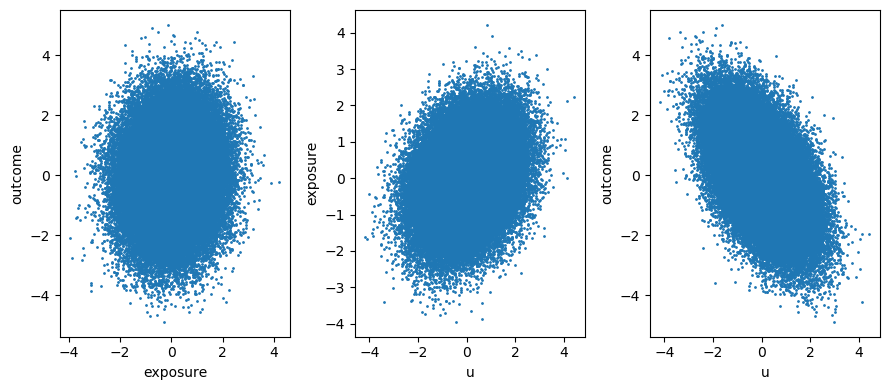

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(9, 4))

pairs = (
    ("exposure", "outcome"),
    ("u", "exposure"),
    ("u", "outcome")
)

for i, (x, y) in enumerate(pairs):
    axes[i].scatter(sim.get_variable_data(x), sim.get_variable_data(y), s=1)
    axes[i].set_xlabel(x)
    axes[i].set_ylabel(y)
    
plt.tight_layout()

In [8]:
# Simulations can be saved using the "dill" package.
# This allows easy sharing of simulation models.
# The original data will be saved.
sim.save_pickle("sim.pkl")
sim2 = mr_sim.Simulation.load_pickle("sim.pkl")
sim2._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,exposure,outcome
0,0.307013,0,1,1,1,0,0,1,0,1,0,0,1,1,2,1,0.768316,0.473755
1,-0.114443,1,0,1,0,0,1,0,0,0,1,0,2,1,1,1,1.459169,-0.363013
2,-0.032193,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0.821650,-0.044556
3,-0.626459,1,0,2,0,0,1,0,1,0,2,0,0,0,2,0,0.450312,-0.412453
4,0.755375,0,0,1,0,1,0,0,0,1,1,0,1,1,2,0,-0.619166,-1.128511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.437773,0,0,2,1,0,0,0,0,0,1,1,0,1,1,1,0.395290,0.230058
99996,0.923299,0,0,0,1,1,0,0,0,0,1,0,1,2,0,0,0.771113,0.216311
99997,-1.157023,0,0,1,0,0,1,0,1,0,0,1,2,0,1,0,-1.375335,0.548671
99998,2.296324,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,-0.861489,-2.769909


In [9]:
# And resampling should also work as expected!
sim2.resample()
sim2._data

,u,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,exposure,outcome
0,0.468728,0,0,1,1,1,0,0,1,0,1,0,0,1,1,1,0.899116,-0.599647
1,0.089326,0,0,0,0,2,1,1,0,0,1,1,2,1,1,0,-0.123041,-0.370473
2,-0.604807,0,0,2,2,0,0,0,0,1,1,0,2,0,1,0,0.161050,0.720452
3,0.366737,1,0,0,0,2,0,0,1,1,1,1,0,0,1,1,-0.296672,-0.189184
4,1.397650,0,0,1,0,1,1,0,1,1,2,0,2,1,1,0,1.036627,-1.803632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.861538,0,1,1,0,0,0,0,1,0,1,0,1,2,1,1,-1.541297,-0.047132
99996,-0.038740,0,0,1,0,0,0,0,2,0,1,0,1,0,0,1,0.483210,0.516153
99997,0.847228,0,0,0,1,0,2,0,0,1,1,0,0,1,0,0,0.099807,-0.101897
99998,1.585270,0,0,0,1,0,1,0,1,1,0,1,1,1,1,1,0.523221,-0.955103
